# This notebook will run stats and averaging of theta dominant frequency

### It depends on the data structure generated by 'Compute_dominant_frequency.ipynb', located in ''../Results/log_welch.npy''

In [2]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter
from scipy import stats 

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper

## pac
from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

/Library/Python/2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/Library/Python/2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/Library/Python/2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/Library/Python/2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/Library/Python/2.7/site-packages/pandas/core/indexes/base.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Exp

# Load study related info

In [3]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle)
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sevssions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle)

# Load theta dominant frequency data

In [4]:
log_welch = np.load('../Results/log_welch.npy')

### Get mean frequency per cues_per_sec condition averaging each electro independently

In [5]:
split_electrodes = False

all_dom = []


for sub in range(len(log_welch)):


    tmp = np.array(log_welch[sub])

    dom = []
    
    
    if split_electrodes == True: iteration_over_electrodes = tmp[:,0]
    else: iteration_over_electrodes = [1]

    for elec in np.unique(iteration_over_electrodes):
                
        elc_dom = []

        for cuesec in np.unique(tmp[:,3]):
            
            if split_electrodes == True:
                idx = np.where(  np.logical_and(  tmp[:,0]==elec , tmp[:,3]==cuesec  )   )[0]
                
            else: idx = np.where( tmp[:,3]==cuesec )[0]

            elc_dom.append( np.mean(  tmp[idx,4] ) )

        dom.append(elc_dom)

    dom = np.array(dom)

    mm = np.mean(dom,axis=0)
    
    

    all_dom.append(mm)
    
all_dom = np.array(all_dom)

In [6]:
all_dom  = stats.zscore( all_dom, axis=1)

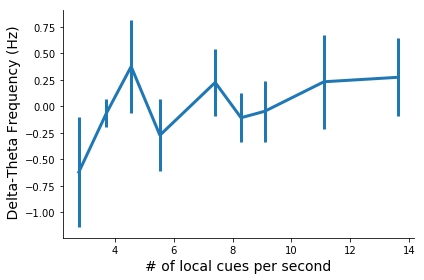

In [7]:
mmm = np.mean(all_dom,axis=0)
sss = stats.sem(all_dom,axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)


ax.errorbar( uni,  mmm , yerr=sss, linewidth=3  )


fig.patch.set_facecolor('xkcd:white')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)

plt.tight_layout()

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')

In [8]:
## Save data as model 
uni_model = np.repeat( uni, 8).reshape(9,8).T

model = np.dstack([ np.ravel(all_dom), np.ravel(uni_model)] )[0]

model = pd.DataFrame(model, columns=['freq','cuesec'] )

model.to_csv('../Results/model_theta_domin_cue_sec.csv',index=True)

In [9]:
result = ols(formula='freq ~ cuesec', data=model).fit()
print(result.summary())  

                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.907
Date:                Mon, 19 Nov 2018   Prob (F-statistic):              0.172
Time:                        17:01:00   Log-Likelihood:                -101.20
No. Observations:                  72   AIC:                             206.4
Df Residuals:                      70   BIC:                             210.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3532      0.282     -1.254      0.2

### Get mean frequency per SPEED condition averaging each electro independently

In [10]:
all_dom = []

for sub in range(len(log_welch)):


    tmp = np.array(log_welch[sub])

    dom = []
    

    if split_electrodes == True: iteration_over_electrodes = tmp[:,0]
    else: iteration_over_electrodes = [1]

    for elec in np.unique(iteration_over_electrodes):

        elc_dom = []

        for cuesec in np.unique(tmp[:,2]):

            if split_electrodes == True:
                idx = np.where(  np.logical_and(  tmp[:,0]==elec , tmp[:,2]==cuesec  )   )[0]
                
            else: idx = np.where( tmp[:,2]==cuesec )[0]

            elc_dom.append( np.mean(  tmp[idx,4] ) )

        dom.append(elc_dom)

    dom = np.array(dom)

    mm = np.mean(dom,axis=0)

    all_dom.append(mm)
    
all_dom = np.array(all_dom)

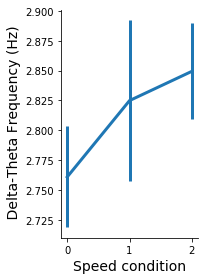

In [11]:
mmm = np.mean(all_dom,axis=0)
sss = stats.sem(all_dom,axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


ax.errorbar( range(3),  mmm , yerr=sss, linewidth=3  )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('Speed condition', fontsize=14)

plt.tight_layout()

# plt.savefig('../Figures/theta_dominant_freq_speed.pdf')

In [12]:
uni_model = np.repeat( range(3), 8).reshape(3,8).T

model = np.dstack([ np.ravel(all_dom), np.ravel(uni_model)] )[0]

model = pd.DataFrame(model, columns=['freq','density'] )

model.to_csv('../Results/model_theta_domin_speed.csv',index=True)

In [13]:
result = ols(formula='freq ~ density', data=model).fit()
print(result.summary())  

                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.544
Date:                Mon, 19 Nov 2018   Prob (F-statistic):              0.227
Time:                        17:01:11   Log-Likelihood:                 13.752
No. Observations:                  24   AIC:                            -23.50
Df Residuals:                      22   BIC:                            -21.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7675      0.046     60.173      0.0

### Get mean frequency per CUES condition averaging each electro independently

In [14]:
all_dom = []

for sub in range(len(log_welch)):


    tmp = np.array(log_welch[sub])

    dom = []
    

    if split_electrodes == True: iteration_over_electrodes = tmp[:,0]
    else: iteration_over_electrodes = [1]

    for elec in np.unique(iteration_over_electrodes):

        elc_dom = []

        for cuesec in np.unique(tmp[:,1]):

            if split_electrodes == True:
                idx = np.where(  np.logical_and(  tmp[:,0]==elec , tmp[:,1]==cuesec  )   )[0]
                
            else: idx = np.where( tmp[:,1]==cuesec )[0]

            elc_dom.append( np.mean(  tmp[idx,4] ) )

        dom.append(elc_dom)

    dom = np.array(dom)

    mm = np.mean(dom,axis=0)

    all_dom.append(mm)
    
all_dom = np.array(all_dom)

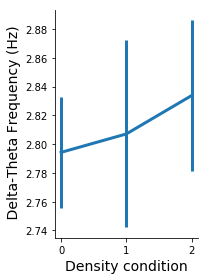

In [15]:
mmm = np.mean(all_dom,axis=0)
sss = stats.sem(all_dom,axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


ax.errorbar( range(3),  mmm , yerr=sss, linewidth=3  )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('Density condition', fontsize=14)

plt.tight_layout()

# plt.savefig('../Figures/theta_dominant_freq_density.pdf')

In [16]:
uni_model = np.repeat( range(3), 8).reshape(3,8).T

model = np.dstack([ np.ravel(all_dom), np.ravel(uni_model)] )[0]

model = pd.DataFrame(model, columns=['freq','speed'] )

model.to_csv('../Results/model_theta_domin_density.csv',index=True)

In [17]:
result = ols(formula='freq ~ speed', data=model).fit()
print(result.summary())  

                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.2896
Date:                Mon, 19 Nov 2018   Prob (F-statistic):              0.596
Time:                        17:01:18   Log-Likelihood:                 13.059
No. Observations:                  24   AIC:                            -22.12
Df Residuals:                      22   BIC:                            -19.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7920      0.047     58.981      0.0

# The big model : 
### dataframe with all subjects data

In [18]:
log_wel_all = []

for ss in range(len(log_welch)):
    
    for tt in range(len(log_welch[ss])):
        
        log_wel_all.append( [ ss, log_welch[ss][tt][1] , log_welch[ss][tt][2] , log_welch[ss][tt][3] , log_welch[ss][tt][4] ] )
        
        
log_wel_all = np.array(log_wel_all)



In [19]:
log_wel_all = pd.DataFrame(log_wel_all, columns=['sub','density','speed','cuesec','freq'] )

In [20]:
result = ols(formula='freq ~ cuesec', data=log_wel_all).fit()

# result = mixedlm("freq ~ density ", data=log_wel_all, groups=log_wel_all['sub'] ).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   freq   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.032
Date:                Mon, 19 Nov 2018   Prob (F-statistic):             0.0450
Time:                        17:01:23   Log-Likelihood:                -513.17
No. Observations:                 810   AIC:                             1030.
Df Residuals:                     808   BIC:                             1040.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7531      0.038     71.623      0.0

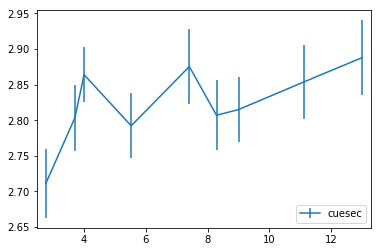

In [21]:
for current_condition in ['cuesec']:

    mmm,sss = [], []

    for ii in np.unique( log_wel_all[current_condition]):

        idx = np.where(  log_wel_all[current_condition] == ii  )[0]
        mmm.append( np.mean(log_wel_all['freq'][idx]) )
        sss.append( stats.sem(log_wel_all['freq'][idx]) )

    plt.errorbar(np.unique( log_wel_all[current_condition]) , mmm , yerr=sss, label=current_condition )

plt.xlim(np.unique( log_wel_all[current_condition]).min()-0.3 , np.unique( log_wel_all[current_condition]).max()+0.3)

plt.legend(loc='lower right')

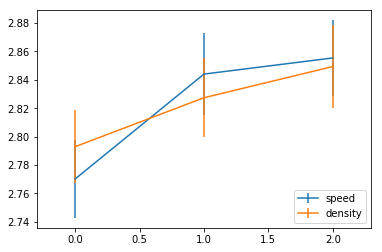

In [22]:
for current_condition in ['speed', 'density']:

    mmm,sss = [], []

    for ii in np.unique( log_wel_all[current_condition]):

        idx = np.where(  log_wel_all[current_condition] == ii  )[0]
        mmm.append( np.mean(log_wel_all['freq'][idx]) )
        sss.append( stats.sem(log_wel_all['freq'][idx]) )

    plt.errorbar(np.unique( log_wel_all[current_condition]) , mmm , yerr=sss, label=current_condition )

plt.xlim(np.unique( log_wel_all[current_condition]).min()-0.3 , np.unique( log_wel_all[current_condition]).max()+0.3)

plt.legend(loc='lower right')

array([[2.78755556, 2.83591111, 2.84444444],
       [2.91555556, 3.04355556, 3.10328889],
       [2.70506667, 2.688     , 2.70506667],
       [2.68231111, 2.69937778, 2.83875556],
       [2.98666667, 2.7904    , 2.7904    ],
       [2.69937778, 2.84444444, 2.90702222],
       [2.76195556, 3.05208889, 2.88142222],
       [2.816     , 2.50311111, 2.59982222]])